# Time Sereis Prediction Project
* project : Liquidity
* author  : Daniel Yanan ZHOU (周亚楠)
* contact : adreambottle@outlook.com
* file    : main.py
* ide     : PyCharm
* time    : 2022-06-13

## 1. View Data
### 1.1. Import libraries needed

Because the data may need some complex libraries, you can check the `requirements.txt` for all the library versions

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from Toolkits import difference, recover
import json

import warnings

warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use("seaborn-whitegrid")


In [56]:
# Processing the data
# Read the data
data = pd.read_csv("Cohorts_rev.csv")
print(data)

      Date  Cohort 1 Rev  Cohort 2 Rev  Cohort 3 Rev  Cohort 4 Rev
0   Jan-20      5.381984           NaN           NaN           NaN
1   Feb-20      4.264969      4.975797           NaN           NaN
2   Mar-20      2.132484      4.264969      5.991266           NaN
3   Apr-20      2.234031      3.858781      4.264969      5.057034
4   May-20      1.929391      2.234031      3.046406      4.264969
5   Jun-20      1.827844      1.919236      1.523203      3.554141
6   Jul-20      1.726297      1.015469      1.015469      2.132484
7   Aug-20      0.812375      0.863148      3.757234      1.523203
8   Sep-20      0.995159      0.767694      0.913922      0.913922
9   Oct-20      0.548353      0.660055      0.507734      0.762820
10  Nov-20      0.406188      0.558508      0.324950      0.520225
11  Dec-20      0.233558      0.426497      0.203094      0.233558
12  Jan-21      0.111702      0.324950      0.101547      0.101547
13  Feb-21      0.096104      0.101547      1.624750      0.05


We can find the column names are not easy to use and the Date is not in the numeric formation
So relabel the data and change the date formation

In [57]:
# Relabel the data and change the Date to datetime format
labels = ["V1", "V2", "V3", "V4"]
data.columns = ["Date"] + labels



# Change date into datetime formate
data["Date"] = pd.to_datetime(data["Date"], format="%b-%y")

# Save an original copy of the data
data_org = data.copy()    
org_columns = list(data.columns)
print(data)

         Date        V1        V2        V3        V4
0  2020-01-01  5.381984       NaN       NaN       NaN
1  2020-02-01  4.264969  4.975797       NaN       NaN
2  2020-03-01  2.132484  4.264969  5.991266       NaN
3  2020-04-01  2.234031  3.858781  4.264969  5.057034
4  2020-05-01  1.929391  2.234031  3.046406  4.264969
5  2020-06-01  1.827844  1.919236  1.523203  3.554141
6  2020-07-01  1.726297  1.015469  1.015469  2.132484
7  2020-08-01  0.812375  0.863148  3.757234  1.523203
8  2020-09-01  0.995159  0.767694  0.913922  0.913922
9  2020-10-01  0.548353  0.660055  0.507734  0.762820
10 2020-11-01  0.406188  0.558508  0.324950  0.520225
11 2020-12-01  0.233558  0.426497  0.203094  0.233558
12 2021-01-01  0.111702  0.324950  0.101547  0.101547
13 2021-02-01  0.096104  0.101547  1.624750  0.050773
14 2021-03-01  0.031806  0.005077  0.203094  0.020309
15 2021-04-01  0.000533  0.000008  0.091392  0.000508


### 1.2. Data Properties
* From the question, we know that the data from different cohord are independent
* The data Data amount is very small

### 1.3. Splitting the data by Moving Window

```
 x1, x2, x3, x4, x5, x6, x7, x8, x9, x10

[x1, x2, x3] => x4
    [x2, x3, x4] => x5
        [x3, x4, x5] => x6
			[x4, x5, x6] => x7
					...
			         [x7, x8, x9] => x10
								         
TrainData = [[x1, x2, x3],
             [x2, x3, x4],
             [x3, x4, x5],
            		 ...
             [x7, x8, x9]]
             
TrainLabel = [x4,
              x5, 
              x6,
              ...
              x10]
```
### 1.4. Visualization and stability test

In [58]:
# View plot and test the stability of the data
def test_stable(ser):
    adf_result = adfuller(ser)
    print(f"The result of ADF Test:\n  t-statistic: {adf_result[0]}\n  p-vale: {adf_result[1]}")

def plot_data(data, title:str):

    plt.figure(figsize=(10, 5))

    labels = ["V1", "V2", "V3", "V4"]
    colors = ["r-", "b-", "g-", "y-"]
    for (i, label) in enumerate(labels):
        plt.plot(data.index, data[label], colors[i], marker="o", label=label)
    
    plt.legend(loc="best")
    plt.title(title, fontweight='heavy')

    plt.show()

### 1.4.1. View the original data

* There is a obvious descending trend.
* The tails of the data is very closed to zero
* The Green one "V3" has two abnormal peaks

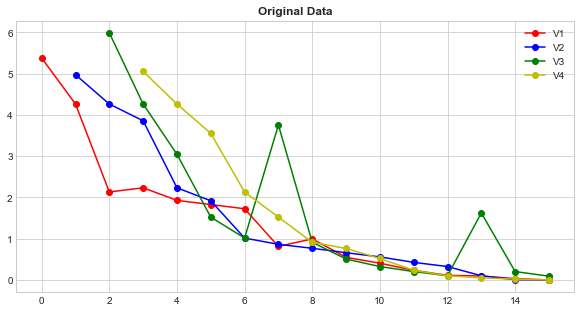

The result of ADF Test:
  t-statistic: -4.515889086025378
  p-vale: 0.00018404129323051113


In [59]:
# View the original data
plot_data(data_org, "Original Data")
test_stable(data_org["V1"])

### 1.4.2. View the log data

* Because the data has an exponential change, so we can consider the log to make the trend not so sharp
* When x is closed to 0, there is  $\lim_{x\to 0}log(1+x) = x$
* But it is still not stable

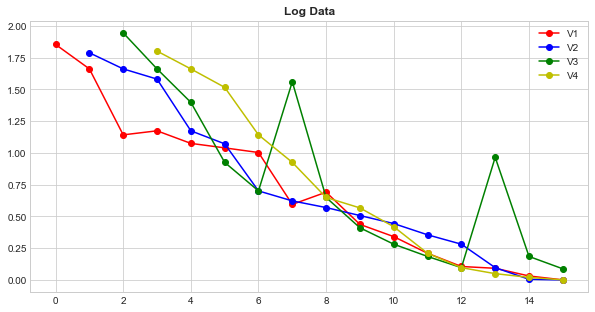

The result of ADF Test:
  t-statistic: -5.588930977014586
  p-vale: 1.342908270805844e-06


In [60]:
# Use log to make the data linearly
data_log = data.copy()
for label in labels:
    data_log[label] = np.log(data[label] + 1)

plot_data(data_log, "Log Data")
test_stable(data_log["V1"].dropna())

### 1.4.3. View the difference data

* The data seems become stable, but the diffence continue to be negive
* If we use the diffence data to perform the predict model, there might be some negative data for the original data
* But the original data cannot be negative

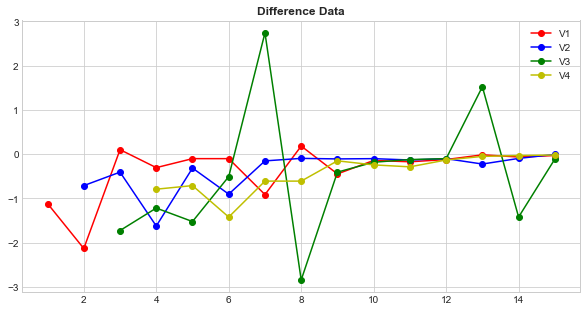

The result of ADF Test:
  t-statistic: 1.0373631690198928
  p-vale: 0.9946449403047174


In [61]:
# Use difference to get the stable data
data_diff = data.copy()
for label in labels:
    data_diff[label] = data[label].diff()

plot_data(data_diff, "Difference Data")
test_stable(data_diff["V1"].dropna())


### 1.4.4. View the division data

* Because there is no build-in division data
* We should build the division data by ourself
* The result seems good, but the influence of the peak by "V3" looks not good.

In [62]:
# difference or division
def difference(ser, method="Div"):
    """
    calculate the difference or the division one by one
    :param ser: The original series
    :param method: difference or division
    :return:
    """
    diff_ser = []
    for i in range(len(ser) - 1):
        if method == "Diff":
            diff_ser.append(ser[i+1] - ser[i])
        if method == "Div":
            diff_ser.append(ser[i+1] / ser[i])

    return diff_ser


# recover from the difference or division
def recover(diff_ser, start_value, method="Div", ):
    """
    Recover from the difference or division
    :param diff_ser:
    :param start_value: add the first value
    :param method:difference or division
    :return:
    """
    diff_ser = diff_ser.dropna()
    diff_ser = np.append(np.array([start_value]), np.array(diff_ser))

    if method == "Diff":
        ser = diff_ser.cumsum()
    elif method == "Div":
        ser = diff_ser.cumprod()
    else:
        raise TypeError("You should only use Diff or Div")

    return ser


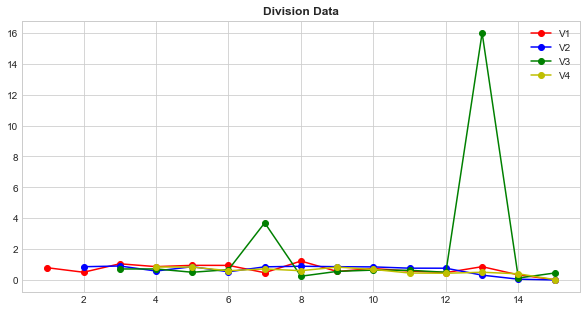

In [63]:
# Use division as difference
data_div = data.copy()
for label in labels:
    data_div[label] = np.append([np.nan], difference(data[label], "Div"))

plot_data(data_div, "Division Data")
# test_stable(data_div["V1"].dropna())

## 2. Series Decomposition Analysis

* Because we consider there are some seasonality for V3
* We need to decompose V3 into trend and seasonality

### 2.1. Series Decomposition Analysis by Multiplicative

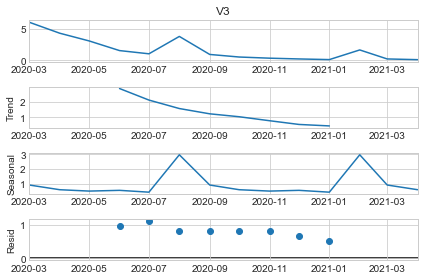

In [64]:
# Series Decomposition Analysis

from statsmodels.tsa.seasonal import seasonal_decompose

data_V3 = data["V3"]
data_V3.index = data["Date"]

decompose_result = seasonal_decompose(data_V3.dropna(),
                                      model='multiplicative',
                                      period=6)
decompose_result.plot()
plt.show()

* We can see obivious seasonality item in the decomposition
* But because if use the trend item to take place of the original data, there will be some negative value
* We are not willing to see negative value happens

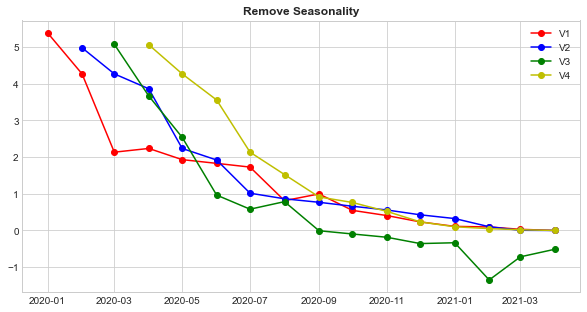

The result of ADF Test:
  t-statistic: -4.515889086025378
  p-vale: 0.00018404129323051113


In [65]:
# y(t) = Level + Trend + Seasonality + Noise
# Remove the influence of Seasonality

data_dec = data.copy()
data_dec.set_index("Date", inplace=True)
seasonality = pd.Series(decompose_result.seasonal)
data_dec["V3"] = data_dec["V3"] - seasonality
plot_data(data_dec, "Remove Seasonality")
test_stable(data_dec["V1"].dropna())

In [66]:
# It is not good, because the value cannot less than zero
print(np.array(data_dec["V3"]))

[        nan         nan  5.07053241  3.66225577  2.53677176  0.96372699
  0.57980468  0.78545556 -0.00681141 -0.09497867 -0.18468453 -0.3563824
 -0.33411721 -1.34702885 -0.71763955 -0.51132086]


### 2.2. Decompose the data by trend average

* Replace the peak value with the average value
* The index of the peak value is 7 and 13
* The next index of next peak is 19

In [67]:
from collections import defaultdict
data_chg = data.copy()

# Store the trend and seasonality in a dictionary
decompose_dict = defaultdict()
decompose_dict[7] = defaultdict()
decompose_dict[13] = defaultdict()
decompose_dict[19] = defaultdict()
decompose_dict[7]["trend"] = (data_chg["V3"][6] + data_chg["V3"][8]) / 2
decompose_dict[13]["trend"] = (data_chg["V3"][12] + data_chg["V3"][14]) / 2
decompose_dict[7]["seasonality"] = data_chg["V3"][7] - decompose_dict[7]["trend"]
decompose_dict[13]["seasonality"] = data_chg["V3"][13] - decompose_dict[13]["trend"]

# Replace the data of peak by its trend
data_chg["V3"][7] = decompose_dict[7]["trend"]
data_chg["V3"][13] = decompose_dict[13]["trend"]

print(np.array(data_chg["V3"]))
print("")
print(f'The seasonality of 7 is:  {decompose_dict[7]["seasonality"] }')
print(f'The seasonality of 13 is: {decompose_dict[13]["seasonality"] }')

[       nan        nan 5.99126572 4.26496881 3.0464063  1.52320315
 1.01546877 0.96469533 0.91392189 0.50773438 0.32495    0.20309375
 0.10154688 0.15232031 0.20309375 0.09139219]

The seasonality of 7 is:  2.7925391050000004
The seasonality of 13 is: 1.4724297100000001


The seasonality of 19 is: 0.7763720289570248


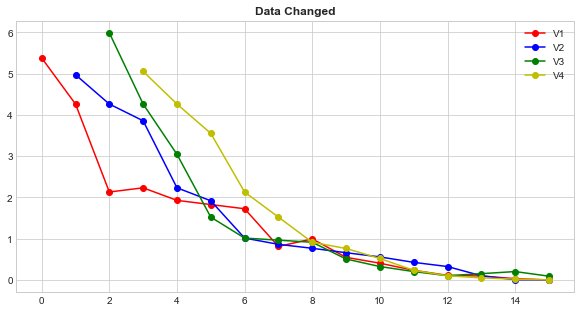

In [68]:
# Calculate and store the shrinkage rate
shrinkrage = decompose_dict[7]["seasonality"] / decompose_dict[13]["seasonality"]
decompose_dict[19]["seasonality"] = decompose_dict[13]["seasonality"] / shrinkrage
print(f'The seasonality of 19 is: {decompose_dict[19]["seasonality"] }')


plot_data(data_chg, "Data Changed")
      

In [69]:
# Save the decompose_dict
import json
to_save_path = "decompose_dict.json"
json_str = json.dumps(decompose_dict)
with open(to_save_path, 'w') as json_file:
    json_file.write(json_str)

### 2.3. Get the stable data in use by decomposition

* First perform the decomposition for V3, and use the trend to take the place of the orginal value
* Perform the cumulativa division for the data, to make the data become stable


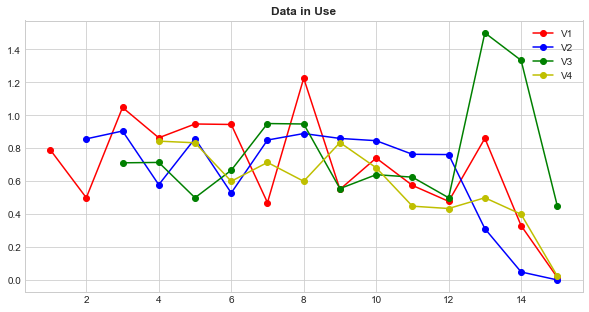

In [70]:
# Use division as difference
data_use = data_chg.copy()
for label in labels:
    data_use[label] = np.append([np.nan], difference(data_use[label], "Div"))

plot_data(data_use, "Data in Use")

# 3. Preidction

* I have developed some models using different models

* LSTM (using keras)
* NeuralNetwork (using pytorch)
    * MLP model
    * CNN model
    * RNN model, like LSTM
* Prophet (using facebook prophet)
* ARIMA (using auto arima)



In [71]:
from LSTM import LSTMModel
from NeuralNetwork import NNModel
from ARIMA import ArimaModel
from Prophet import ProphetModel
# from ClassicModel import

In [72]:
# Load the data
data = data_use[["V1", "V2", "V3", "V4"]]
date_index = data_use["Date"]

## 3.1. LSTM

In [73]:
# LSTM
DataModel = LSTMModel()
DataModel.fit(data)
DataModel.train(epochs=20)

Epoch 1/20
30/30 - 1s - loss: 0.2285
Epoch 2/20
30/30 - 0s - loss: 0.1283
Epoch 3/20
30/30 - 0s - loss: 0.0671
Epoch 4/20
30/30 - 0s - loss: 0.0442
Epoch 5/20
30/30 - 0s - loss: 0.0419
Epoch 6/20
30/30 - 0s - loss: 0.0386
Epoch 7/20
30/30 - 0s - loss: 0.0395
Epoch 8/20
30/30 - 0s - loss: 0.0450
Epoch 9/20
30/30 - 0s - loss: 0.0400
Epoch 10/20
30/30 - 0s - loss: 0.0414
Epoch 11/20
30/30 - 0s - loss: 0.0412
Epoch 12/20
30/30 - 0s - loss: 0.0410
Epoch 13/20
30/30 - 0s - loss: 0.0392
Epoch 14/20
30/30 - 0s - loss: 0.0386
Epoch 15/20
30/30 - 0s - loss: 0.0377
Epoch 16/20
30/30 - 0s - loss: 0.0385
Epoch 17/20
30/30 - 0s - loss: 0.0461
Epoch 18/20
30/30 - 0s - loss: 0.0381
Epoch 19/20
30/30 - 0s - loss: 0.0433
Epoch 20/20
30/30 - 0s - loss: 0.0404


          V1        V2        V3        V4
0        NaN       NaN       NaN       NaN
1   1.189011       NaN       NaN       NaN
2   0.750800  1.285943       NaN       NaN
3   1.571352  1.357295  1.068258       NaN
4   1.295673  0.869095  1.071886  1.265311
5   1.421137  1.288862  0.750800  1.250267
6   1.416756  0.794404  1.000533  0.900640
7   0.706729  1.275240  1.425080  1.071886
8   1.837140  1.334295  1.421137  0.900640
9   0.827249  1.289907  0.834044  1.252265
10  1.111526  1.269477  0.960576  1.023472
11  0.863180  1.145833  0.938100  0.674315
12  0.718226  1.143238  0.750800  0.653078
13  1.290769  0.469850  2.249200  0.750800
14  0.497499  0.076520  1.999467  0.600960
15  0.026699  0.003997  0.675880  0.039060
16  0.572191  0.496333  0.929286  0.534248
17  0.544834  0.551057  0.793894  0.534557
18  0.662755  0.533472  0.909197  0.582783
19  0.600913  0.514742  0.911754  0.596686
20  0.547087  0.509813  0.746547  0.535672
21  0.609146  0.571709  0.755000  0.596244
22  0.60688

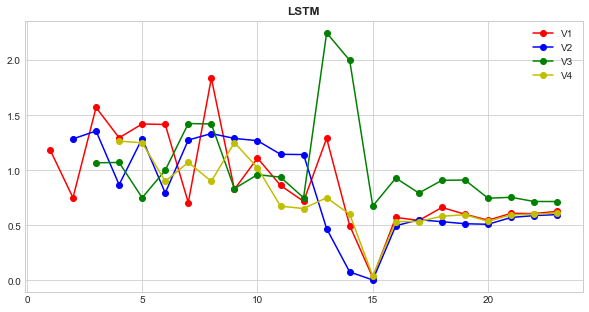

In [74]:
result_data_LSTM = DataModel.predict(data)

print(result_data_LSTM)
plot_data(result_data_LSTM, "LSTM")

## 3.2.1. Neural Network (MLP)

In [75]:
# Neural Network MLP
DataModel = NNModel("MLP")
DataModel.fit(data)
DataModel.train(epochs=20)


Training the NN model
Epoch: 0, Loss: 0.15253727
Epoch: 1, Loss: 0.00890612
Epoch: 2, Loss: 0.00042273
Epoch: 3, Loss: 0.02178491
Epoch: 4, Loss: 0.01341575
Epoch: 5, Loss: 0.01546470
Epoch: 6, Loss: 0.01414222
Epoch: 7, Loss: 0.03162968
Epoch: 8, Loss: 0.00395776
Epoch: 9, Loss: 0.00728147
Epoch: 10, Loss: 0.16925265
Epoch: 11, Loss: 0.19028762
Epoch: 12, Loss: 0.00251519
Epoch: 13, Loss: 0.00063892
Epoch: 14, Loss: 0.01037589
Epoch: 15, Loss: 0.12847497
Epoch: 16, Loss: 0.18659365
Epoch: 17, Loss: 0.00806350
Epoch: 18, Loss: 0.29011446
Epoch: 19, Loss: 0.02345710
Best Epoch: 2, Best Loss: 0.00042273


MLP_m(
  (Linear1): Linear(in_features=5, out_features=3, bias=True)
  (Linear2): Linear(in_features=3, out_features=1, bias=True)
  (Sigmoid): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
)


Finished Predict
          V1        V2        V3        V4
0        NaN       NaN       NaN       NaN
1   1.189011       NaN       NaN       NaN
2   0.750800  1.285943       NaN       NaN
3   1.571352  1.357295  1.068258       NaN
4   1.295673  0.869095  1.071886  1.265311
5   1.421137  1.288862  0.750800  1.250267
6   1.416756  0.794404  1.000533  0.900640
7   0.706729  1.275240  1.425080  1.071886
8   1.837140  1.334295  1.421137  0.900640
9   0.827249  1.289907  0.834044  1.252265
10  1.111526  1.269477  0.960576  1.023472
11  0.863180  1.145833  0.938100  0.674315
12  0.718226  1.143238  0.750800  0.653078
13  1.290769  0.469850  2.249200  0.750800
14  0.497499  0.076520  1.999467  0.600960
15  0.026699  0.003997  0.675880  0.039060
16  0.699703  0.688630  0.715033  0.691127
17  0.683718  0.698711  0.685698  0.692001
18  0.699812  0.691782  0.700990  0.689145
19  0.701231  0.694055  0.717553  0.702665
20  0.682634  0.682538  0.693819  0.683087
21  0.694653  0.694140  0.694968  0.

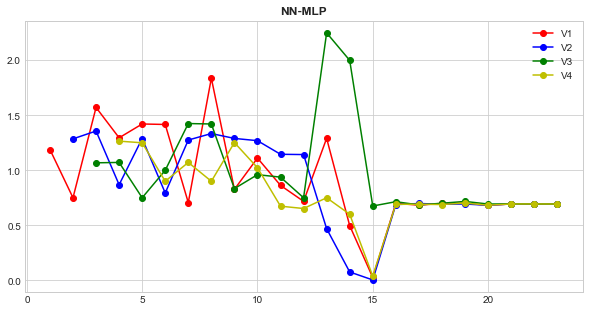

In [76]:
result_data = DataModel.predict(data)

print(result_data)
plot_data(result_data, "NN-MLP")

## 3.2.2. Neural Network (CNN)

In [77]:
# Neural Network CNN
DataModel = NNModel("CNN")
DataModel.fit(data)
DataModel.train(epochs=20)


Training the NN model
Epoch: 0, Loss: 0.08741570
Epoch: 1, Loss: 0.00358901
Epoch: 2, Loss: 0.00145010
Epoch: 3, Loss: 0.02216130
Epoch: 4, Loss: 0.03951781
Epoch: 5, Loss: 0.01046123
Epoch: 6, Loss: 0.04409107
Epoch: 7, Loss: 0.02192505
Epoch: 8, Loss: 0.00004471
Epoch: 9, Loss: 0.01461782
Epoch: 10, Loss: 0.24236690
Epoch: 11, Loss: 0.15899672
Epoch: 12, Loss: 0.06135825
Epoch: 13, Loss: 0.01653150
Epoch: 14, Loss: 0.00586908
Epoch: 15, Loss: 0.12293955
Epoch: 16, Loss: 0.15173541
Epoch: 17, Loss: 0.01652234
Epoch: 18, Loss: 0.27664870
Epoch: 19, Loss: 0.00032333
Best Epoch: 8, Best Loss: 0.00004471


CNN_m(
  (Linear1): Linear(in_features=5, out_features=8, bias=True)
  (Conv1d): Conv1d(1, 3, kernel_size=(5,), stride=(1,))
  (relu): ReLU(inplace=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (Linear2): Linear(in_features=12, out_features=1, bias=True)
)


Finished Predict
          V1        V2        V3        V4
0        NaN       NaN       NaN       NaN
1   1.189011       NaN       NaN       NaN
2   0.750800  1.285943       NaN       NaN
3   1.571352  1.357295  1.068258       NaN
4   1.295673  0.869095  1.071886  1.265311
5   1.421137  1.288862  0.750800  1.250267
6   1.416756  0.794404  1.000533  0.900640
7   0.706729  1.275240  1.425080  1.071886
8   1.837140  1.334295  1.421137  0.900640
9   0.827249  1.289907  0.834044  1.252265
10  1.111526  1.269477  0.960576  1.023472
11  0.863180  1.145833  0.938100  0.674315
12  0.718226  1.143238  0.750800  0.653078
13  1.290769  0.469850  2.249200  0.750800
14  0.497499  0.076520  1.999467  0.600960
15  0.026699  0.003997  0.675880  0.039060
16  0.625289  0.637240  0.709466  0.634517
17  0.655704  0.657928  0.661104  0.649095
18  0.700503  0.662694  0.724693  0.691737
19  0.660816  0.650398  0.700153  0.662247
20  0.666218  0.663851  0.679126  0.666419
21  0.671462  0.672742  0.674554  0.

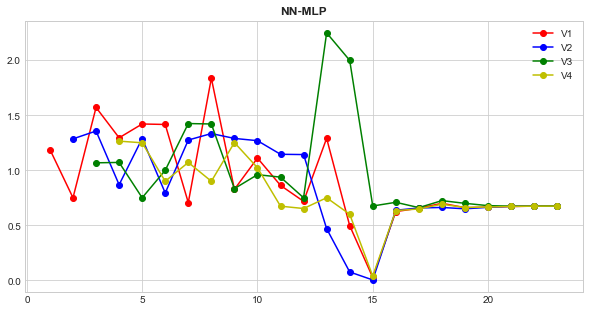

In [78]:
result_data = DataModel.predict(data)

print(result_data)
plot_data(result_data, "NN-MLP")


Finished Predict
          V1        V2        V3        V4
0        NaN       NaN       NaN       NaN
1   1.189011       NaN       NaN       NaN
2   0.750800  1.285943       NaN       NaN
3   1.571352  1.357295  1.068258       NaN
4   1.295673  0.869095  1.071886  1.265311
5   1.421137  1.288862  0.750800  1.250267
6   1.416756  0.794404  1.000533  0.900640
7   0.706729  1.275240  1.425080  1.071886
8   1.837140  1.334295  1.421137  0.900640
9   0.827249  1.289907  0.834044  1.252265
10  1.111526  1.269477  0.960576  1.023472
11  0.863180  1.145833  0.938100  0.674315
12  0.718226  1.143238  0.750800  0.653078
13  1.290769  0.469850  2.249200  0.750800
14  0.497499  0.076520  1.999467  0.600960
15  0.026699  0.003997  0.675880  0.039060
16  0.625289  0.637240  0.709466  0.634517
17  0.655704  0.657928  0.661104  0.649095
18  0.700503  0.662694  0.724693  0.691737
19  0.660816  0.650398  0.700153  0.662247
20  0.666218  0.663851  0.679126  0.666419
21  0.671462  0.672742  0.674554  0.

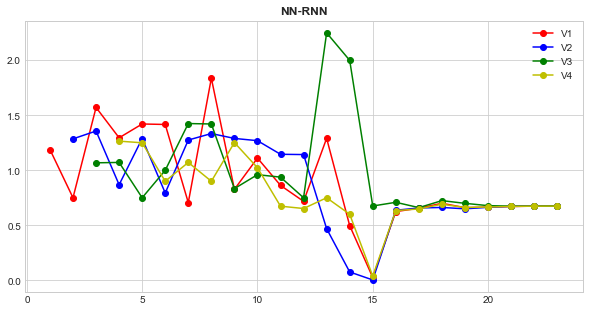

In [79]:
result_data = DataModel.predict(data)

print(result_data)
plot_data(result_data, "NN-RNN")

## 3.2.3. Neural Network (RNN)

In [80]:
# Neural Network RNN
DataModel = NNModel("LSTM")
DataModel.fit(data)
DataModel.train(epochs=20)


Training the NN model
Epoch: 0, Loss: 0.11718543
Epoch: 1, Loss: 0.05223661
Epoch: 2, Loss: 0.02076965
Epoch: 3, Loss: 0.01992505
Epoch: 4, Loss: 0.01081492
Epoch: 5, Loss: 0.02989135
Epoch: 6, Loss: 0.01416607
Epoch: 7, Loss: 0.00105596
Epoch: 8, Loss: 0.18095772
Epoch: 9, Loss: 0.12435605
Epoch: 10, Loss: 0.01111702
Epoch: 11, Loss: 0.07483444
Epoch: 12, Loss: 0.01811047
Epoch: 13, Loss: 0.02828445
Epoch: 14, Loss: 0.00017498
Epoch: 15, Loss: 0.00061145
Epoch: 16, Loss: 0.03699518
Epoch: 17, Loss: 0.00002925
Epoch: 18, Loss: 0.01172432
Epoch: 19, Loss: 0.00768576
Best Epoch: 17, Best Loss: 0.00002925


LSTM_m(
  (lstm): LSTM(5, 10, num_layers=2)
  (Linear): Linear(in_features=10, out_features=1, bias=True)
  (Sigmoid): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
)

## 3.3. Prophet

In [81]:
# Prophet
DataModel = ProphetModel()
DataModel.fit(data, date_index)
DataModel.train()
result_data = DataModel.predict(data)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 11.



Training the Prophet model

Training the Prophet model for column V1

Training the Prophet model for column V2

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 10.




Initial log joint probability = 2.56129
Iteration  1. Log joint probability =    7.08668. Improved by 4.52539.
Iteration  2. Log joint probability =    14.1429. Improved by 7.05618.
Iteration  3. Log joint probability =      14.54. Improved by 0.397132.
Iteration  4. Log joint probability =    15.5862. Improved by 1.04624.
Iteration  5. Log joint probability =    15.8663. Improved by 0.280082.
Iteration  6. Log joint probability =    15.8844. Improved by 0.0181036.
Iteration  7. Log joint probability =      15.89. Improved by 0.00554764.
Iteration  8. Log joint probability =    15.8952. Improved by 0.00519944.
Iteration  9. Log joint probability =    15.8956. Improved by 0.000482603.
Iteration 10. Log joint probability =    15.8971. Improved by 0.00141045.
Iteration 11. Log joint probability =    15.8986. Improved by 0.00158272.
Iteration 12. Log joint probability =    15.8998. Improved by 0.00120658.
Iteration 13. Log joint probability =    15.9002. Improved by 0.000336959.
Iteratio

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 8.


. Improved by 7.2064e-05.
Iteration 28. Log joint probability =    12.2102. Improved by 0.000256934.
Iteration 29. Log joint probability =    12.2103. Improved by 8.29062e-05.
Iteration 30. Log joint probability =    12.2104. Improved by 0.000110999.
Iteration 31. Log joint probability =    12.2105. Improved by 6.46586e-05.
Iteration 32. Log joint probability =    12.2105. Improved by 1.93272e-05.
Iteration 33. Log joint probability =    12.2105. Improved by 1.54835e-05.
Iteration 34. Log joint probability =    12.2105. Improved by 2.27705e-06.
Iteration 35. Log joint probability =    12.2105. Improved by 1.41565e-06.
Iteration 36. Log joint probability =    12.2105. Improved by 9.20141e-06.
Iteration 37. Log joint probability =    12.2105. Improved by 2.85333e-07.
Iteration 38. Log joint probability =    12.2105. Improved by 2.40284e-06.
Iteration 39. Log joint probability =    12.2105. Improved by 2.91709e-06.
Iteration 40. Log joint probability =    12.2105. Improved by 1.86087e-06.


Finished Predict
          V1        V2        V3        V4
0        NaN       NaN       NaN       NaN
1   0.792453       NaN       NaN       NaN
2   0.500000  0.857143       NaN       NaN
3   1.047619  0.904762  0.711864       NaN
4   0.863636  0.578947  0.714286  0.843373
5   0.947368  0.859091  0.500000  0.833333
6   0.944444  0.529101  0.666667  0.600000
7   0.470588  0.850000  0.950000  0.714286
8   1.225000  0.889412  0.947368  0.600000
9   0.551020  0.859788  0.555556  0.834667
10  0.740741  0.846154  0.640000  0.681976
11  0.575000  0.763636  0.625000  0.448956
12  0.478261  0.761905  0.500000  0.434783
13  0.860364  0.312500  1.500000  0.500000
14  0.330952  0.050000  1.333333  0.400000
15  0.016751  0.001600  0.450000  0.025000
16  0.398694  0.279624  0.932409  0.224313
17  0.361348  0.229418  0.955135  0.168842
18  0.325206  0.180830  0.977127  0.115160
19  0.287860  0.130624  0.999853  0.059689
20  0.250514  0.080417  1.022578  0.004218
21  0.214373  0.031830  1.044571 -0.

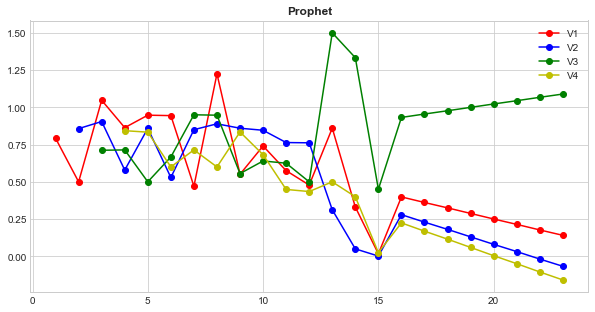

In [82]:
result_data = DataModel.predict(data)

print(result_data)
plot_data(result_data, "Prophet")

## 3.4. Arima

In [83]:
# Arima
DataModel = ArimaModel()
DataModel.fit(data, date_index)
DataModel.train()
result_data = DataModel.predict(data)


Training the auto_arima model

Training the auto_arima model for column V1
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=18.006, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13.290, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16.273, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=12.618, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=14.617, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=14.082, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=11.715, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=11.888, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=13.599, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=12.940, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=12.605, Time=0.0


Finished Predict
          V1        V2        V3        V4
0        NaN       NaN       NaN       NaN
1   0.792453       NaN       NaN       NaN
2   0.500000  0.857143       NaN       NaN
3   1.047619  0.904762  0.711864       NaN
4   0.863636  0.578947  0.714286  0.843373
5   0.947368  0.859091  0.500000  0.833333
6   0.944444  0.529101  0.666667  0.600000
7   0.470588  0.850000  0.950000  0.714286
8   1.225000  0.889412  0.947368  0.600000
9   0.551020  0.859788  0.555556  0.834667
10  0.740741  0.846154  0.640000  0.681976
11  0.575000  0.763636  0.625000  0.448956
12  0.478261  0.761905  0.500000  0.434783
13  0.860364  0.312500  1.500000  0.500000
14  0.330952  0.050000  1.333333  0.400000
15  0.016751  0.001600  0.450000  0.025000
16  0.568779  0.001600  0.450000  0.221791
17  0.202753  0.001600  0.450000  0.167247
18  0.278662  0.001600  0.450000  0.112703
19  0.384986  0.001600  0.450000  0.058159
20  0.248283  0.001600  0.450000  0.003614
21  0.325087  0.001600  0.450000 -0.

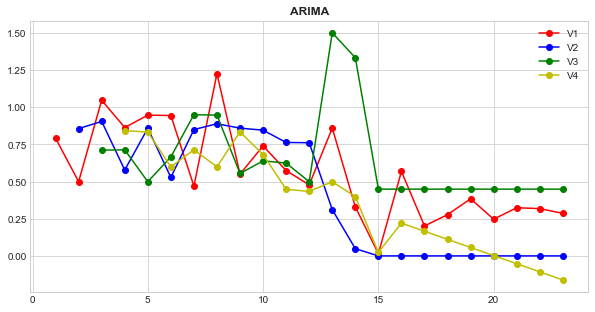

In [84]:
result_data = DataModel.predict(data)

print(result_data)
plot_data(result_data, "ARIMA")

## 4. Recover the data

### 4.1. Recover the data by the cumprod (cuz cumulative division)

         Date        V1            V2        V3        V4
0  2020-01-01  5.381984           NaN       NaN       NaN
1  2020-02-01  4.264969  4.975797e+00       NaN       NaN
2  2020-03-01  2.132484  4.264969e+00  5.991266       NaN
3  2020-04-01  2.234031  3.858781e+00  4.264969  5.057034
4  2020-05-01  1.929391  2.234031e+00  3.046406  4.264969
5  2020-06-01  1.827844  1.919236e+00  1.523203  3.554141
6  2020-07-01  1.726297  1.015469e+00  1.015469  2.132484
7  2020-08-01  0.812375  8.631485e-01  3.757234  1.523203
8  2020-09-01  0.995159  7.676944e-01  0.913922  0.913922
9  2020-10-01  0.548353  6.600547e-01  0.507734  0.762820
10 2020-11-01  0.406188  5.585078e-01  0.324950  0.520225
11 2020-12-01  0.233558  4.264969e-01  0.203094  0.233558
12 2021-01-01  0.111702  3.249500e-01  0.101547  0.101547
13 2021-02-01  0.096104  1.015469e-01  1.624750  0.050773
14 2021-03-01  0.031806  5.077344e-03  0.203094  0.020309
15 2021-04-01  0.000533  8.123750e-06  0.091392  0.000508
16 2021-05-01 

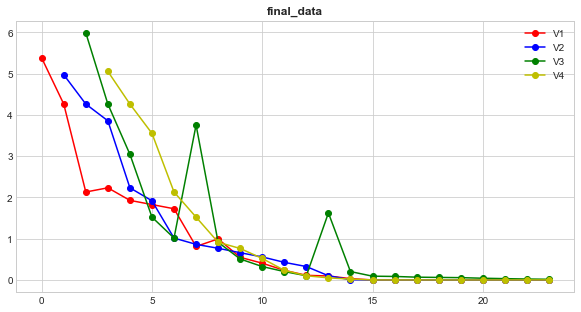

In [85]:
### Use the data forecasted by LSTM using keras
recover_data = {}
result_data = result_data_LSTM
for label in result_data.columns:
    # The start value is the last valid data in the original data on 2021-04-01
    start_value = np.array(data_org[label].dropna())[-1]

    # We only use the data after 2021-04-01, the last 8 data
    ser_before = result_data[label][-8:]

    # recover the original data from the division data
    ser_after = recover(ser_before, start_value, "Div")

    # remove the first original value
    recover_data[label] = ser_after[1:]

# Concat the original data and the predicted data together
recover_data["Date"] = [pd.to_datetime(f"2021-{month}") for month in range(5, 13)]
recover_frame = pd.DataFrame(recover_data)
final_data = pd.concat([data_org, recover_frame])
final_data.reset_index(drop=True, inplace=True)

print(final_data)
plot_data(final_data, "final_data")

### 4.2. Add the seasonality for V3

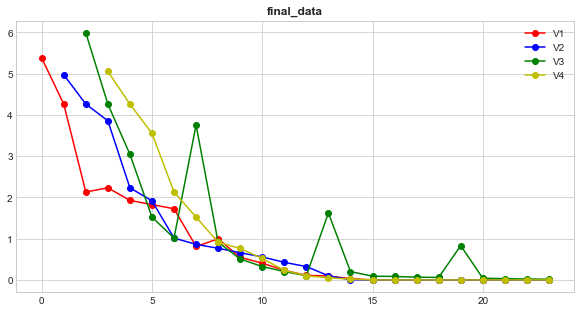

In [86]:
# Add the seasonality for V3
final_data["V3"][19] = final_data["V3"][19] + decompose_dict[19]["seasonality"]
final_data.columns = org_columns
plot_data(final_data, "final_data")

In [87]:
final_data

,Date,V1,V2,V3,V4
0,2020-01-01,5.381984,NaN,NaN,NaN
1,2020-02-01,4.264969,4.975797e+00,NaN,NaN
2,2020-03-01,2.132484,4.264969e+00,5.991266,NaN
3,2020-04-01,2.234031,3.858781e+00,4.264969,5.057034
4,2020-05-01,1.929391,2.234031e+00,3.046406,4.264969
5,2020-06-01,1.827844,1.919236e+00,1.523203,3.554141
6,2020-07-01,1.726297,1.015469e+00,1.015469,2.132484
7,2020-08-01,0.812375,8.631485e-01,3.757234,1.523203
8,2020-09-01,0.995159,7.676944e-01,0.913922,0.913922
9,2020-10-01,0.548353,6.600547e-01,0.507734,0.762820
